In [1]:
import numpy as np
from os import listdir
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from os import listdir
import matplotlib.patches as mpatches
from scipy import signal
import scipy.stats as scistats
from scipy.stats import chi2
import gsw
import geopy.distance
import signalz
import scipy
from scipy import signal
from scipy.interpolate import interp1d
from scipy.interpolate import BarycentricInterpolator
import math
#import jmkxarray
from matplotlib import ticker
from matplotlib.lines import Line2D
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
import numpy as np
import xarray as xr

In [2]:
all_sections_combined = xr.open_dataset('/Users/Lauryn/THESIS/CPROOF_Work/Files/good_files/all_files15.nc')

In [3]:
climate = '/Users/Lauryn/THESIS/CPROOF_Work/Climatology/LineP_climatology_1956to2012.nc'  

with xr.open_dataset(climate) as climate:
    display(climate)
    
    #find distance from Station 1
    climate['distance'] =[geopy.distance.geodesic((48.56127328, -125.53143223), (climate.latitude[i],climate.longitude[i])).km for i in range(len(climate.longitude))]


<xarray.Dataset> Size: 20MB
Dimensions:              (charsInName: 3, stations: 27, dim1: 12, dim2: 860)
Dimensions without coordinates: charsInName, stations, dim1, dim2
Data variables: (12/14)
    LinePstationNames    (charsInName, stations) |S1 81B ...
    longitude            (stations) float64 216B ...
    latitude             (stations) float64 216B ...
    month                (dim1) float64 96B ...
    pressure             (dim2) float64 7kB ...
    temperature          (stations, dim2, dim1) float64 2MB ...
    ...                   ...
    salinity             (stations, dim2, dim1) float64 2MB ...
    salinity_std         (stations, dim2, dim1) float64 2MB ...
    salinity_noYears     (stations, dim2, dim1) float64 2MB ...
    density              (stations, dim2, dim1) float64 2MB ...
    density_std          (stations, dim2, dim1) float64 2MB ...
    density_noYears      (stations, dim2, dim1) float64 2MB ...
Attributes:
    description:             Monthly climatology of temperature, salinity and...
    Additional Information:  DFO Line P monitoring website: https://www.water...
    creation_date:           14-Nov-2024 13:30:17
    created_by:              tetjana.ross@dfo-mpo.gc.ca

In [4]:
transfer_path = '/Users/Lauryn/THESIS/CPROOF_Work/Files/transfer_functions/'

transfer = [ 'walle2019_jul_WE_transfer_functions.nc', 'walle2019_dec_EW_transfer_functions.nc',
            'walle2019_dec_WE_transfer_functions.nc','walle2021_EW_transfer_functions.nc',
            'walle2021_WE_transfer_functions.nc','rosie2022_EW_transfer_functions.nc',
            'rosie2022_WE_transfer_functions.nc','rosie2023_EW_transfer_functions.nc', 
            'rosie2023_WE_transfer_functions.nc','walle2023_EW_transfer_functions.nc', 
            'walle2023_WE_transfer_functions.nc','rosie2024_EW_transfer_functions.nc',
            'rosie2024_WE_transfer_functions.nc','walle2024_EW_transfer_functions.nc', 
            'walle2024_EW_transfer_functions.nc']


# Plots

In [5]:
all_spectra = xr.open_dataset('all_spectra.nc')
off_spectra = xr.open_dataset('off_spectra.nc')
near_spectra = xr.open_dataset('near_spectra.nc')

model_path = '/Users/Lauryn/THESIS/CPROOF_Work/NEPOM/'


all_synthetic = xr.open_dataset(model_path+'all_synthetic_files.nc')

mod_all_spectra= xr.open_dataset('mod_spectra_all.nc')
mod_near_spectra=xr.open_dataset('mod_near_spectra.nc')
mod_off_spectra=xr.open_dataset('mod_off_spectra.nc')

ds = xr.open_dataset('glider_spectra_confidence_bounds.nc')
ds2 = xr.open_dataset('model_spectra_confidence_bounds.nc')


# Spectrograms

In [18]:

# Define missions
mission = ['A', 'B', 'C', 'D', 'E', 'F', 
           'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O']
timebin_colors = ['purple', 'seagreen', 'orange']

# Add small and large spaces using zero-width columns
width_ratios = [1,0.02, 1, 0.1, 1,0.02, 1, 0.1, 1,0.02, 1, 0.1]  # 0.1 for small spaces, 0.3 for larger space

# Create figure and subplots with adjusted spacing
fig, axs = plt.subplots(5, 12, figsize=(17, 20), sharex=True, sharey=True, 
                        gridspec_kw={'width_ratios': width_ratios, 'wspace': 0, 'hspace': 0.3})  

# Define subplot locations with gaps

off_ax = [(0,0),(0,4) ,(0,8),(1,0), (1,4) ,(1,8),(2,0),(2,4) ,(2,8),
          (3,0),(3,4) ,(3,8),(4,0), (4,4),(4,8)]

near_ax = [(0,2),(0,6),(0,10),
           (1,2), (1,6), (1,10), (2,2),(2,6),(2,10), (3,2), (4,2), (3,6),(3,10), (4,6),(4,10)  ]


# Tiny subplots that should have no x-axis labels or ticks
tiny_ax = [(0,1), (1,1), (2,1), (3,1), (4,1), 
           (0,3), (1,3), (2,3), (3,3), (4,3),
           (0,5), (1,5), (2,5), (3,5), (4,5),
           (0,7), (1,7), (2,7), (3,7), (4,7),
           (0,9), (1,9), (2,9), (3,9), (4,9),
          (0,11), (1,11), (2,11), (3,11), (4,11)]

# Plot nearshore spectra
ims = []
for i in range(15):
    spec = near_spectra.sel(file=i, depth=slice(110,920), k=slice(1/128,1/6))
    ax = axs[near_ax[i]]
    im = ax.pcolormesh(spec.k, -spec.depth, spec.spectra*(2*np.pi*spec.k)**2,
                        norm='log', vmin=1e-3, vmax=2e-1,rasterized=True)
    ax.set_xscale('log')
    #ax.set_xlim(1/260, 1/6)
    ims.append(im)
    if i <= 2:
        color = timebin_colors[0]  # Missions A–C (0–2)
    elif i <= 6:
        color = timebin_colors[1]  # Missions D–G (3–6)
    else:
        color = timebin_colors[2]  # Missions H–O (7–14)
    ax.set_title('Nearshore: ' + mission[i], fontsize=15, c=color)
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)

# Plot offshore spectra
for i in range(15):
    spec = off_spectra.sel(file=i, depth=slice(110,920), k=slice(1/128,1/6))
    ax = axs[off_ax[i]]
    im = ax.pcolormesh(spec.k, -spec.depth, spec.spectra*(2*np.pi*spec.k)**2,
                        norm='log', vmin=1e-3, vmax=2e-1,rasterized=True)
    ax.set_xscale('log')
    #ax.set_xlim(1/260, 1/6)
    ims.append(im)
    
    if i <= 2:
        color = timebin_colors[0]  # Missions A–C (0–2)
    elif i <= 6:
        color = timebin_colors[1]  # Missions D–G (3–6)
    else:
        color = timebin_colors[2]  # Missions H–O (7–14)
        
    ax.set_title('Offshore: ' + mission[i], fontsize=15, c = color)
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)

# Remove x labels and tick marks from the tiny subplots
for ax_pos in tiny_ax:
    axs[ax_pos].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

# Add colorbar
cbar_ax = fig.add_axes([0.93, 0.15, 0.02, 0.7])  # Adjust the size of the colorbar axis
cbar = fig.colorbar(ims[0], cax=cbar_ax, label=r'$(2\pi k)^2 \theta^{*}$ variability (cpkm) ') 
cbar.ax.tick_params(labelsize=15)
cbar.ax.yaxis.label.set_size(25)

timebin_colors = ['purple', 'seagreen', 'orange']

# Loop through both near_ax and off_ax
for i in range(15):  # i = mission index 0 to 14
    if i <= 2:
        color = timebin_colors[0]  # Missions A–C (0–2)
    elif i <= 6:
        color = timebin_colors[1]  # Missions D–G (3–6)
    else:
        color = timebin_colors[2]  # Missions H–O (7–14)

    # Color the nearshore plot
    ax_near = axs[near_ax[i]]
    for spine in ax_near.spines.values():
        spine.set_edgecolor(color)
        spine.set_linewidth(5.5)

    # Color the offshore plot
    ax_off = axs[off_ax[i]]
    for spine in ax_off.spines.values():
        spine.set_edgecolor(color)
        spine.set_linewidth(5.5)
        
custom_lines = [Line2D([0], [0], color='purple', lw=7),
                Line2D([0], [0], color='seagreen', lw=7),
                Line2D([0], [0], color='orange', lw=7)]

fig.legend(custom_lines, ['2019–2020', '2021–2022', '2023–2024'], 
           loc='upper center', bbox_to_anchor=(0.5, 0.98), ncol=3, fontsize=18)

for ax_pos in tiny_ax:
    ax = axs[ax_pos]
    ax.set_facecolor('none')  # Make background transparent
    for spine in ax.spines.values():
        spine.set_visible(False)  # Hide all spines
    ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    
axs[-1, -6].set_xlabel('k (cpkm)', fontsize=25)
axs[2, 0].set_ylabel('Isopycnal Depth (m)', fontsize=25)

plt.savefig("spectrogram.pdf", format="pdf", bbox_inches="tight")


# Function for plots 

In [6]:
def spectra_groups(file, title,ax):

    group1 = slice(110, 225); group2 = slice(225,490); group3=slice(490,920)
    labels=['1: 110-225m', '2: 225-490m','3: 490-920']
    
    gr1 = file.sel(depth=(group1),k=slice(1e-3,1.7e-1))
    PSD1_mean = gr1.blocked_iso_potential_temp_PSD.mean('depth')
    gr2 = file.sel(depth=(group2),k=slice(1e-3,1.7e-1))
    PSD2_mean = gr2.blocked_iso_potential_temp_PSD.mean('depth')
    gr3 = file.sel(depth=(group3),k=slice(1e-3,1.7e-1))
    PSD3_mean = gr3.blocked_iso_potential_temp_PSD.mean('depth')

    ax.loglog(gr1.k, PSD1_mean*(2*np.pi*gr1.k)**2, c='blue', label=labels[0])
    ax.loglog(gr2.k, PSD2_mean*(2*np.pi*gr2.k)**2, c='green',  label=labels[1])
    ax.loglog(gr3.k, PSD3_mean*(2*np.pi*gr3.k)**2, c='orange', label=labels[2])
    ax.loglog(gr1.k,gr1.k**1/10**0, c='black', alpha = 0.5,  ls='--',label='k^(1)')
    ax.loglog(gr1.k,gr1.k**(1/3)/10**1, c='black', alpha = 0.5, label='k^(1/3)')

    
    plt.ylim(4*10e-5,10e-2)
        
    A1, b1, error_slope1,k_best_fit = linear_regression(gr1.k, PSD1_mean * (2 * np.pi * gr1.k)**2)
    axs[0].loglog(gr1.k, PSD1_mean * (2 * np.pi * gr1.k)**2)

    A2, b2, error_slope2,k_best_fit = linear_regression(gr1.k, PSD2_mean * (2 * np.pi * gr1.k)**2)
    axs[1].loglog(gr2.k, PSD2_mean * (2 * np.pi * gr2.k)**2)


    A3, b3, error_slope3,k_best_fit = linear_regression(gr1.k, PSD3_mean * (2 * np.pi * gr1.k)**2)
    axs[2].loglog(gr3.k, PSD3_mean * (2 * np.pi * gr3.k)**2)

    ax.set_title(title)

In [7]:
def linear_regression(k, PSD):
    k_best_fit = np.linspace(1 / 144, 1/6, 41)
    PSD_fit = np.interp(k_best_fit, k, PSD)
    
    lx, ly = [[math.log10(V) for V in v] for v in (k_best_fit, PSD_fit)]
    n = len(k_best_fit)
    sum_x = sum(x for x in lx)
    sum_y = sum(y for y in ly)
    sum_x2 = sum(x**2 for x in lx)
    sum_y2 = sum(y**2 for y in ly)
    sum_xy = sum(x * y for x, y in zip(lx, ly))

    # coefficients of a straight line "y = a + b x" in log-log space
    b = (n * sum_xy - sum_x * sum_y) / (n * sum_x2 - sum_x**2)
    a = (sum_y - b * sum_x) / n
    A = pow(10, a)

    y_log_pred = [a + b * x for x in lx]  # Predicted values in log space
    y_log_residuals = [(y - y_pred) for y, y_pred in zip(ly, y_log_pred)]
    y_log_residuals_squared = [res**2 for res in y_log_residuals]

    # Sum of squared residuals in log-log space
    y_log_yi2 = sum(y_log_residuals_squared)

    # Compute error of the slope
    error_slope = math.sqrt(y_log_yi2 / (n - 2))
    
    return A, b, error_slope, k_best_fit



In [8]:
def avg_line(k_best_fit, gr1_slope, gr1_b, gr2_slope, gr2_b, gr3_slope, gr3_b, gr1_slope_error,
             gr2_slope_error, gr3_slope_error, i):
    ## avg 1
    gr1_slope = xr.DataArray(gr1_slope, dims=('section', 'k'))    
    gr1_mean = gr1_slope.mean('section')
    
    axs[0, i].plot(k_best_fit, gr1_mean, c='black', linewidth=3)
    error = np.sqrt(np.sum(gr1_slope_error)) 
    txt = f'Average slope: {np.round(np.mean(gr1_b), 2)} +/- {np.round(error, 2)} '
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    axs[0, i].text(0.1, 0.1, txt, transform=axs[0, i].transAxes, fontsize=10,
                   bbox=props, verticalalignment='top', c='k')
    
    axs[0, i].plot(k_best_fit, k_best_fit**1 / 10**1, c='blue', linewidth=1)
    axs[0, i].plot(k_best_fit, k_best_fit**0 * 10**-2, c='red', linewidth=1)
    #axs[0, i].plot(k_best_fit, k_best_fit**(1 / 3) / 10**1, c='gray', linewidth=1)

    ## avg 2
    gr2_slope = xr.DataArray(gr2_slope, dims=('section', 'k'))    
    gr2_mean = gr2_slope.mean('section')

    axs[1, i].plot(k_best_fit, gr2_mean, c='black', linewidth=3)
    error = np.sqrt(np.sum(gr2_slope_error)) 
    txt = f'Average slope: {np.round(np.mean(gr2_b), 2)} +/- {np.round(error, 2)}'
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    axs[1, i].text(0.1, 0.1, txt, transform=axs[1, i].transAxes, fontsize=10,
                   bbox=props, verticalalignment='top', c='k')

    axs[1, i].plot(k_best_fit, k_best_fit**1 / 10**1, c='blue', linewidth=1)
    #axs[1, i].plot(k_best_fit, k_best_fit**(1 / 3) / 10**1, c='gray', linewidth=1)
    axs[1, i].plot(k_best_fit, k_best_fit**0 * 10**-2, c='red', linewidth=1)

    ## avg 3
    gr3_slope = xr.DataArray(gr3_slope, dims=('section', 'k'))    
    gr3_mean = gr3_slope.mean('section')

    axs[2, i].plot(k_best_fit, gr3_mean, c='black', linewidth=3)
    error = np.sqrt(np.sum(gr3_slope_error)) 
    txt = f'Average slope: {np.round(np.mean(gr3_b), 2)} +/- {np.round(error, 2)}'
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    axs[2, i].text(0.1, 0.1, txt, transform=axs[2, i].transAxes, fontsize=10,
                   bbox=props, verticalalignment='top', c='k')

    axs[2, i].plot(k_best_fit, k_best_fit**1 / 10**1, c='blue', linewidth=1)
    axs[2, i].plot(k_best_fit, k_best_fit**0 * 10**-2, c='red', linewidth=1)
    #axs[2, i].plot(k_best_fit, k_best_fit**(1 / 3) / 10**1, c='gray', linewidth=1)


In [9]:
def spectra_groups_nearoff(file, j):
    group1 = slice(110, 225)
    group2 = slice(225, 490)
    group3 = slice(490, 920)
    labels = ['1: 110-225m', '2: 225-490m', '3: 490-920']
    c = 'k'
    ls = '--'
    
    gr1 = file.sel(depth=(group1), k=slice(1/300,1/6))
    PSD1_mean = gr1.spectra.mean('depth')
    gr2 = file.sel(depth=(group2), k=slice(1/300,1/6))
    PSD2_mean = gr2.spectra.mean('depth')
    gr3 = file.sel(depth=(group3), k=slice(1/300,1/6))
    PSD3_mean = gr3.spectra.mean('depth')
    
    
    A1, b1, error_slope1,k_best_fit = linear_regression(gr1.k, PSD1_mean * (2 * np.pi * gr1.k)**2)
    axs[0, j].loglog(gr1.k, PSD1_mean * (2 * np.pi * gr1.k)**2, c=c, ls=ls)
    gr1_slope.append([A1 * pow(x, b1) for x in k_best_fit])
    gr1_b.append(b1)
    gr1_slope_error.append(error_slope1**2)

    A2, b2, error_slope2,k_best_fit = linear_regression(gr1.k, PSD2_mean * (2 * np.pi * gr1.k)**2)
    axs[1, j].loglog(gr2.k, PSD2_mean * (2 * np.pi * gr2.k)**2, c=c, ls=ls)
    gr2_slope.append([A2 * pow(x, b2) for x in k_best_fit])
    gr2_b.append(b2)
    gr2_slope_error.append(error_slope2**2)

    A3, b3, error_slope3,k_best_fit = linear_regression(gr1.k, PSD3_mean * (2 * np.pi * gr1.k)**2)
    axs[2, j].loglog(gr3.k, PSD3_mean * (2 * np.pi * gr3.k)**2, c=c, ls=ls)
    gr3_slope.append([A3 * pow(x, b3) for x in k_best_fit])
    gr3_b.append(b3)
    gr3_slope_error.append(error_slope3**2)


    
    return k_best_fit


In [21]:
def spectra_groups_nearoff_no_d(file, i,j,label):
    group1 = slice(110, 920)

    labels = ['1: 110-225m', '2: 225-490m', '3: 490-920']
    c = 'k'
    ls = '--'
    
    gr1 = file.sel(depth=(group1), k=slice(1/600,1/6))
    PSD1_mean = gr1.spectra.mean('depth')

    
    A1, b1, error_slope1,k_best_fit = linear_regression(gr1.k, PSD1_mean * (2 * np.pi * gr1.k)**2)
    axs[j, i].loglog(gr1.k, PSD1_mean * (2 * np.pi * gr1.k)**2, c=c, ls=ls,label = label)
    gr1_slope.append([A1 * pow(x, b1) for x in k_best_fit])
    gr1_b.append(b1)
    gr1_slope_error.append(error_slope1**2)
    #PSD.append(PSD1_mean)
    
    return k_best_fit
def spectra_groups_nearoff_no_d2(file,ax,label):
    group1 = slice(110, 920)

    labels = ['1: 110-225m', '2: 225-490m', '3: 490-920']
    c = 'k'
    ls = '--'
    
    gr1 = file.sel(depth=(group1), k=slice(1/600,1/6))
    PSD1_mean = gr1.spectra.mean('depth')

    
    A1, b1, error_slope1,k_best_fit = linear_regression(gr1.k, PSD1_mean * (2 * np.pi * gr1.k)**2)
    ax.loglog(gr1.k, PSD1_mean * (2 * np.pi * gr1.k)**2, c=c, ls=ls,label = label)
    gr1_slope.append([A1 * pow(x, b1) for x in k_best_fit])
    gr1_b.append(b1)
    gr1_slope_error.append(error_slope1**2)
    #PSD.append(PSD1_mean)

    return k_best_fit

def avg_line_no_d(k_best_fit, gr1_slope, gr1_b, gr2_slope, gr2_b, gr3_slope, gr3_b, gr1_slope_error,
             gr2_slope_error, gr3_slope_error, i,j,label):
    ## avg 1
    gr1_slope = xr.DataArray(gr1_slope, dims=('section', 'k'))    
    gr1_mean = gr1_slope.mean('section')
    
    axs[j, i].plot(k_best_fit, gr1_mean, c='black', linewidth=3, label = label)
    error = np.sqrt(np.sum(gr1_slope_error)) 
    txt = f'Average slope: {np.round(np.mean(gr1_b), 2)} +/- {np.round(error, 1)} '
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    axs[j, i].text(0.03, 0.1, txt, transform=axs[j, i].transAxes, fontsize=11,
                   bbox=props, verticalalignment='top', c='k')
    
    axs[j, i].plot(k_best_fit, k_best_fit**1 *10**-1, c='blue', linewidth=1)
    axs[j, i].plot(k_best_fit, k_best_fit**0 * 10**-2, c='red', linewidth=1)
    #axs[0, i].plot(k_best_fit, k_best_fit**(1 / 3) / 10**1, c='gray', linewidth=1)

    
def avg_line_no_d2(k_best_fit, gr1_slope, gr1_b, gr2_slope, gr2_b, gr3_slope, gr3_b, gr1_slope_error,
             gr2_slope_error, gr3_slope_error, ax,label,PSD):
    ## avg 1
    gr1_slope = xr.DataArray(gr1_slope, dims=('section', 'k'))    
    gr1_mean = gr1_slope.mean('section')
    
    ax.plot(k_best_fit, gr1_mean, c='black', linewidth=3, label = label)
    error = np.sqrt(np.sum(gr1_slope_error)) 
    txt = f'Average slope: {np.round(np.mean(gr1_b), 2)} +/- {np.round(error, 1)} '
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    ax.text(0.03, 0.1, txt, transform=ax.transAxes, fontsize=11,
                   bbox=props, verticalalignment='top', c='k')

    #PSD= xr.DataArray(PSD, dims=('section', 'k')).mean('section') 

    #ax.loglog(k_best_fit, PSD*(2*np.pi*k_best_fit)**2, c='k', linewidth=3, label=label)
    
    ax.plot(k_best_fit, k_best_fit**1 *10**-1, c='blue', linewidth=1)
    ax.plot(k_best_fit, k_best_fit**0 * 10**-2, c='red', linewidth=1)
    #axs[0, i].plot(k_best_fit, k_best_fit**(1 / 3) / 10**1, c='gray', linewidth=1)

    


In [11]:
def spectra_groups_ALL(file, ax, c, ci,y_bottom,ls,label):

    
    gr1 = file.sel(depth=slice(110,920))
    PSD1_mean = gr1.spectra.mean('depth')

    
    #A1, b1, error_slope1,k_best_fit = linear_regression(gr1.k, PSD1_mean * (2 * np.pi * gr1.k)**2)
    ax.loglog(gr1.k, PSD1_mean * (2 * np.pi * gr1.k)**2, c=c,ls=ls, label=label)
    #gr1_slope.append([A1 * pow(x, b1) for x in k_best_fit])
    #gr1_b.append(b1)
    #gr1_slope_error.append(error_slope1**2)


    ci_lower = ci['ci_lower'].sel(file=file.file.values, depth=slice(110,920)).mean('depth')
    ci_upper = ci['ci_upper'].sel(file=file.file.values, depth=slice(110,920)).mean('depth')
    
    lower = ci_lower * (2 * np.pi * gr1.k.values)**2  
    upper = ci_upper * (2 * np.pi * gr1.k.values)**2  
    
    # Compute average error range
    valid = np.isfinite(lower) & np.isfinite(upper)
    mean_lower = np.nanmean(lower[valid])
    mean_upper = np.nanmean(upper[valid])
    error_ratio = mean_upper / mean_lower  # multiplicative factor
        
    # Set bottom of the box
    y_bottom = y_bottom  # place it lower on the plot
    y_top = y_bottom * error_ratio  # keep same *log height*
        
    # Choose x-position away from data
    x_left = 1e-3
    x_right = 1.01e-3
        
    # Draw box
    ax.fill_between(
            [x_left, x_right],
            [y_bottom, y_bottom],
            [y_top, y_top],
            color=c,  zorder=2
        )
    


In [12]:
def spectra_groups_ALL_no_error(file, ax, c,ls):

    
    gr1 = file.sel(depth=slice(110,920))
    PSD1_mean = gr1.spectra.mean('depth')

    
    #A1, b1, error_slope1,k_best_fit = linear_regression(gr1.k, PSD1_mean * (2 * np.pi * gr1.k)**2)
    ax.loglog(gr1.k, PSD1_mean * (2 * np.pi * gr1.k)**2, c=c,ls=ls)
    #gr1_slope.append([A1 * pow(x, b1) for x in k_best_fit])
    #gr1_b.append(b1)
    #gr1_slope_error.append(error_slope1**2)


    
    #return k_best_fit



# Model Comparison 

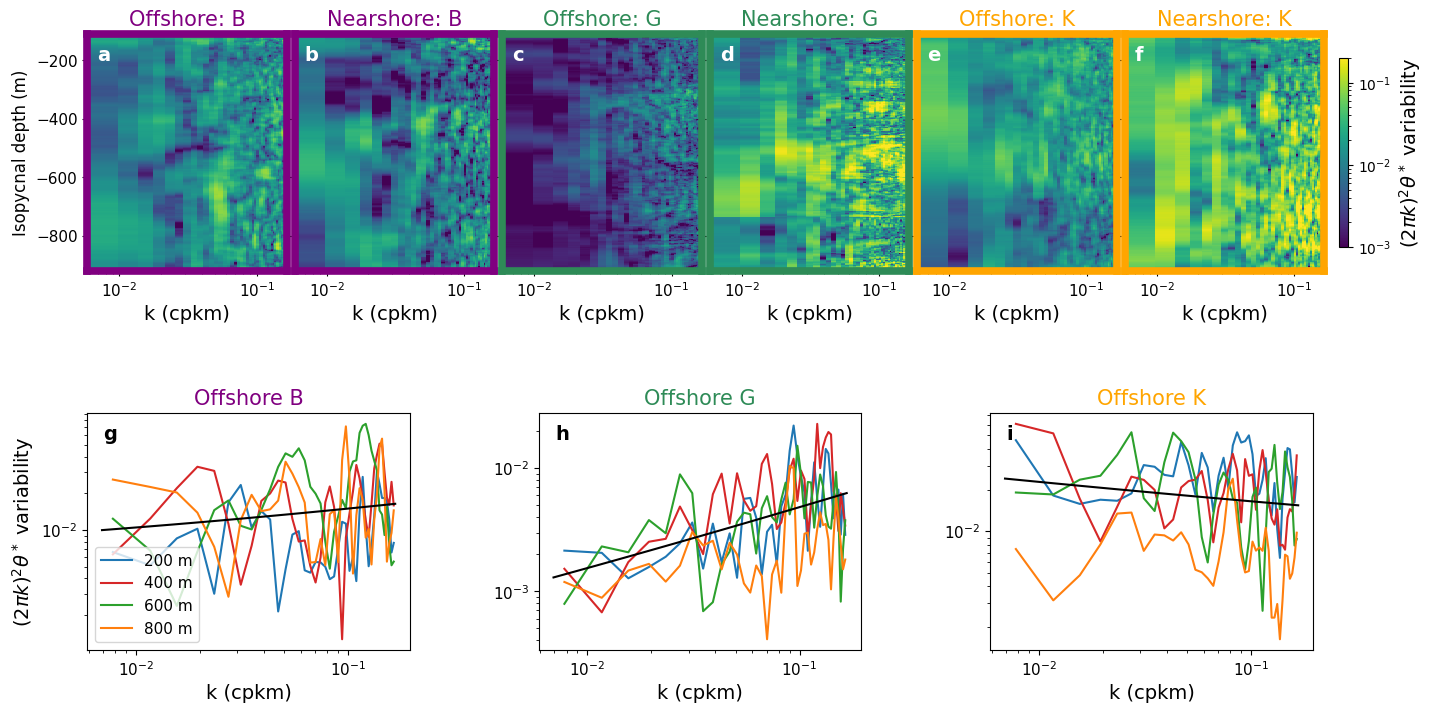

In [13]:
c = ['purple', 'seagreen', 'orange']

mission = ['A', 'B', 'C', 'D', 'E', 'F',
           'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O']
target_files = [1, 6, 10]
timebin_colors = ['purple', 'seagreen', 'orange']
depths = [200, 400, 600, 800]
colors = ['tab:blue', 'tab:red', 'tab:green', 'tab:orange']
titles_row2 = ['Offshore B', 'Offshore G', 'Offshore K']
titles_row3 = ['A–C: 2019–2020', 'D–G: 2021–2022', 'H–O: 2023–2024']

# Create a 2-row GridSpec: 6 columns for top row, 3 columns for bottom two
fig = plt.figure(figsize=(19, 8))

# Top: full-width 6 columns, bottom: nested layout in columns 1–4
outer_gs = gridspec.GridSpec(2, 6, height_ratios=[2, 2], hspace=0.6, wspace=0.04)

# === Row 1: Full-width
axs1 = [fig.add_subplot(outer_gs[0, i]) for i in range(6)]

ims = []

for idx, file_idx in enumerate(target_files):
    col = idx * 2
    color = timebin_colors[0] if file_idx <= 2 else (timebin_colors[1] if file_idx <= 6 else timebin_colors[2])

    # Offshore
    ax_off = axs1[col]
    spec_off = off_spectra.sel(file=file_idx, depth=slice(110, 920), k=slice(1/128, 1/6))
    im = ax_off.pcolormesh(spec_off.k, -spec_off.depth, spec_off.spectra * (2 * np.pi * spec_off.k)**2,
                           norm='log', vmin=1e-3, vmax=2e-1, rasterized=True)
    ax_off.set_xscale('log')
    ax_off.set_title(f'Offshore: {mission[file_idx]}', fontsize=15, color=color)
    ax_off.tick_params(labelsize=11)
    if idx == 0:
        ax_off.set_ylabel("Isopycnal depth (m)", fontsize=12)
    else:
        ax_off.set_yticklabels([])
    for spine in ax_off.spines.values():
        spine.set_edgecolor(color)
        spine.set_linewidth(5.5)
    ims.append(im)

    # Nearshore
    ax_near = axs1[col + 1]
    spec_near = near_spectra.sel(file=file_idx, depth=slice(110, 920), k=slice(1/128, 1/6))
    im = ax_near.pcolormesh(spec_near.k, -spec_near.depth, spec_near.spectra * (2 * np.pi * spec_near.k)**2,
                            norm='log', vmin=1e-3, vmax=2e-1, rasterized=True)
    ax_near.set_xscale('log')
    ax_near.set_title(f'Nearshore: {mission[file_idx]}', fontsize=15, color=color)
    ax_near.set_yticklabels([])
    ax_near.tick_params(labelsize=11)
    for spine in ax_near.spines.values():
        spine.set_edgecolor(color)
        spine.set_linewidth(5.5)
    ims.append(im)

# === ROW 2: Center-aligned Slope Fits ===
inner_gs2 = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=outer_gs[1, 0:5], wspace=0.4)
axs2 = [fig.add_subplot(inner_gs2[0, i]) for i in range(3)]

for j, file_idx in enumerate(target_files):
    gr1_slope = []
    for i, dpth in enumerate(depths):
        gr1 = off_spectra.isel(file=file_idx, depth=dpth).sel(k=slice(1/300, 1/6))
        A1, b1, err, k_fit = linear_regression(gr1.k, gr1.spectra * (2 * np.pi * gr1.k)**2)
        gr1_slope.append([A1 * pow(x, b1) for x in k_fit])
        axs2[j].loglog(gr1.k, gr1.spectra * (2 * np.pi * gr1.k)**2, c=colors[i], label=f'{dpth} m')
    axs2[j].plot(k_fit, np.mean(gr1_slope, axis=0), c='k')
    axs2[j].set_title(titles_row2[j], fontsize=15,c=timebin_colors[j])
    axs2[j].tick_params(labelsize=11)

axs2[0].legend(fontsize=11, loc='lower left')

#=== Colorbar and Legend ===
cbar = fig.colorbar(ims[0], ax=axs1, orientation='vertical', pad=0.01, shrink=0.8)
cbar.ax.set_ylabel(r'$(2\pi k)^2 \theta^*$ variability', fontsize=14)

#custom_lines = [Line2D([0], [0], color=c, lw=7) for c in timebin_colors]
#fig.legend(custom_lines, ['2019–2020', '2021–2022', '2023–2024'],
#          loc='upper center', bbox_to_anchor=(0.45, 0.98), ncol=3, fontsize=15)

labels = ['a', 'c', 'e']
count=0
for ax in axs1[::2]:  # every left subplot in top row (Offshore)
    ax.set_xlabel('k (cpkm)', fontsize=14)
    ax.text(0.05, 0.95, labels[count], transform=ax.transAxes,
            fontsize=14, fontweight='bold', va='top', ha='left',color='white')
    count+=1

labels = ['b', 'd', 'f']
count=0
for ax in axs1[1::2]:  # every right subplot in top row (Nearshore)
    ax.set_xlabel('k (cpkm)', fontsize=14)
    ax.text(0.05, 0.95, labels[count], transform=ax.transAxes,
            fontsize=14, fontweight='bold', va='top', ha='left',color='white')
    count+=1

label=['g','h','i']
count=0
for ax in axs2:
    ax.set_xlabel('k (cpkm)', fontsize=14)
    ax.text(0.05, 0.95, label[count], transform=ax.transAxes,
            fontsize=14, fontweight='bold', va='top', ha='left',color='k')
    count+=1


# Label y-axes clearly
axs2[0].set_ylabel(r'$(2\pi k)^2 \theta^*$ variability', fontsize=14)
axs =[axs1,axs2]

plt.savefig("spectra_nod.pdf", format="pdf", bbox_inches="tight")


/var/folders/4f/2tlph0394xl3ljq0c7zz4t380000gn/T/ipykernel_85196/2295036835.py:220: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  plt.savefig("spectra_all_scales.pdf", format="pdf", bbox_inches="tight")
/var/folders/4f/2tlph0394xl3ljq0c7zz4t380000gn/T/ipykernel_85196/2295036835.py:220: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  plt.savefig("spectra_all_scales.pdf", format="pdf", bbox_inches="tight")
/opt/anaconda3/envs/eos431/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


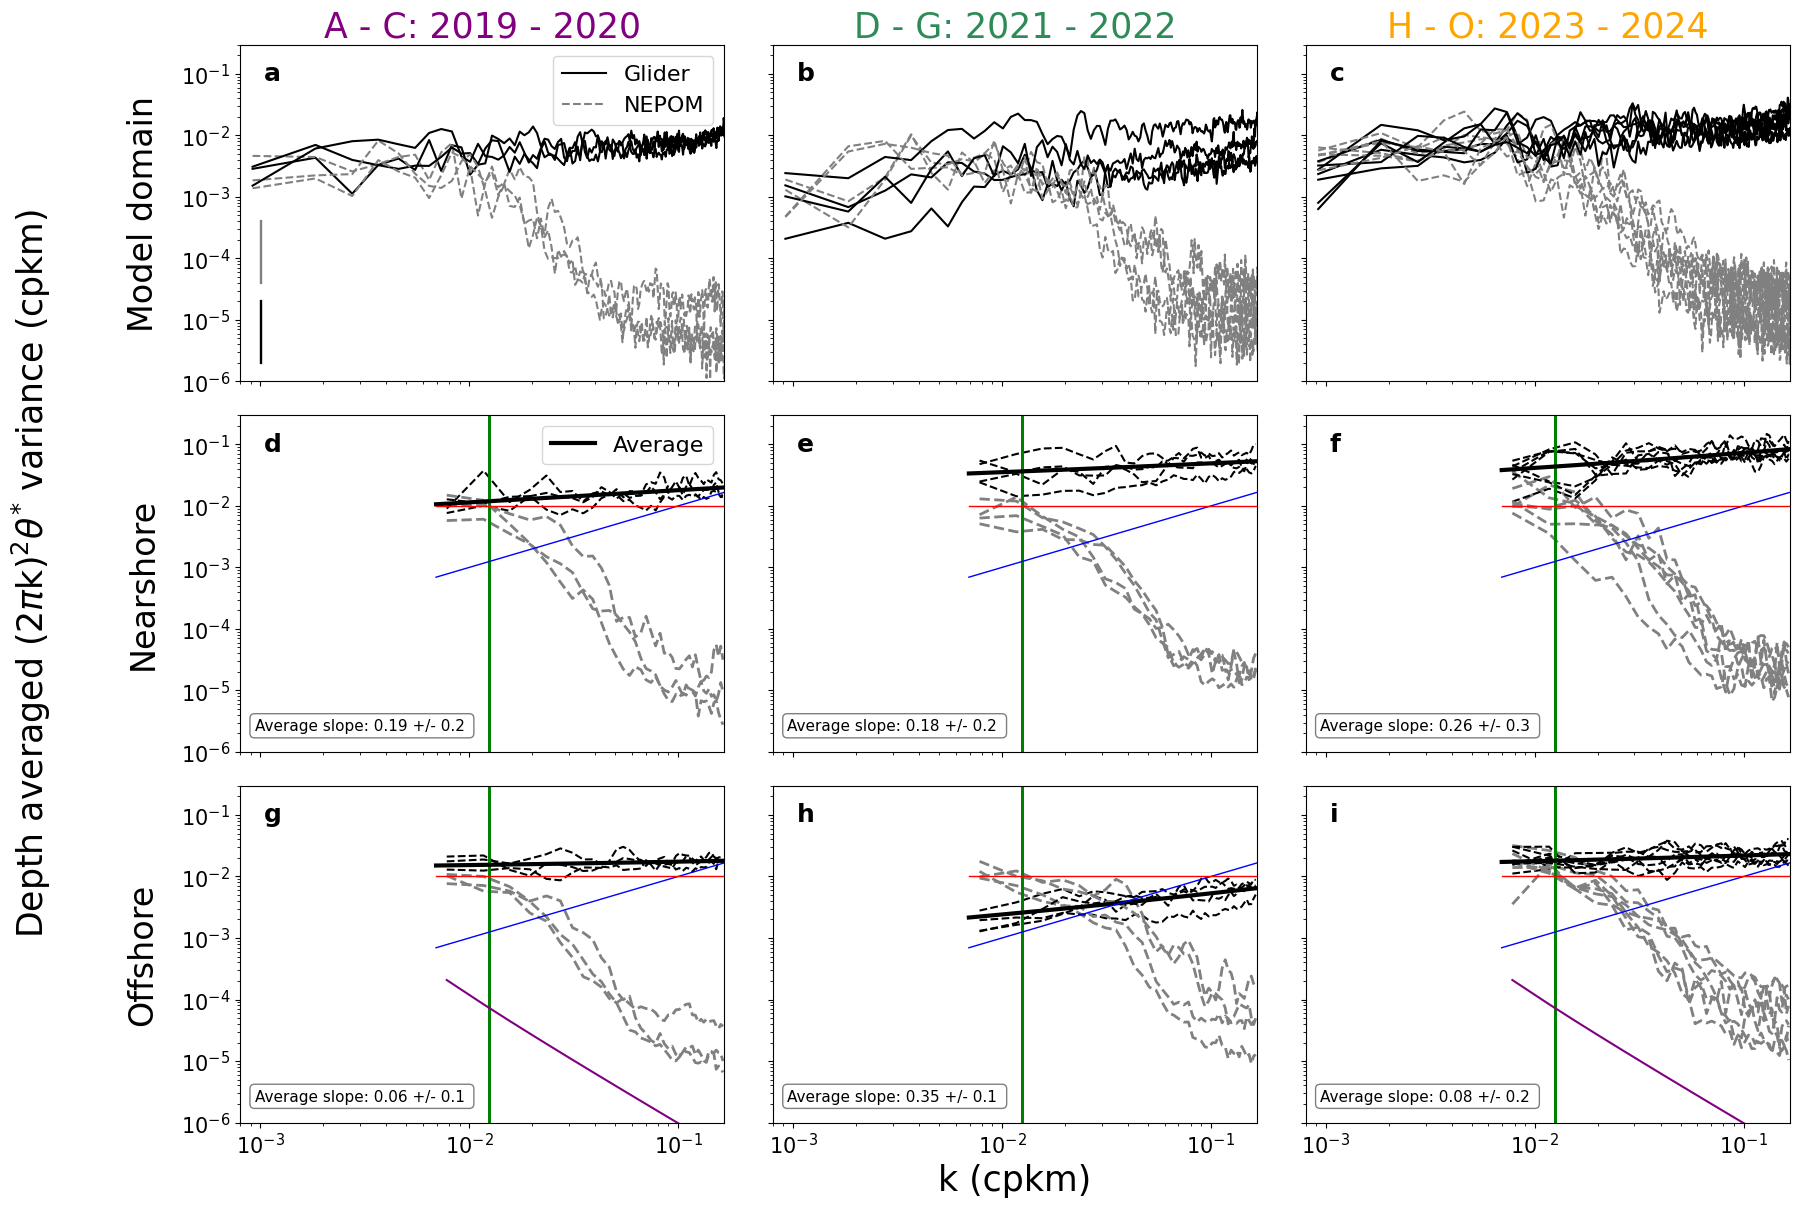

In [29]:
# Create a 3-row GridSpec: 6 columns for top row, 3 columns for bottom two
fig = plt.figure(figsize=(20, 14),layout='constrained')

# Top: full-width 3 columns, bottom: nested layout in columns 1–4
outer_gs = gridspec.GridSpec(3, 3, height_ratios=[2,2, 2], hspace=0.1, wspace=0.03)

# === Row 1: Full-width
inner_gs1 = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=outer_gs[0, :], wspace=0.1)
axs1 = [fig.add_subplot(inner_gs1[0, i]) for i in range(3)]
for i in range(3):
    axs1[i].set_ylim(1e-6,3e-1)
    axs1[i].set_xlim(8e-4,1/6)

spectra_groups_ALL(all_spectra.isel(file=0),axs1[0],'k',ds, 2e-6,'-', 'Glider')
spectra_groups_ALL(mod_all_spectra.isel(file=0),axs1[0],'gray',ds2, 4e-5,'--','NEPOM')

axs1[0].legend(loc='upper right', fontsize=16)


for i in range(1,3): 
    spectra_groups_ALL_no_error(all_spectra.isel(file=i),axs1[0],'k' ,'-')
    spectra_groups_ALL_no_error(mod_all_spectra.isel(file=i),axs1[0],'gray','--' )

for i in range(3,7): 
    spectra_groups_ALL_no_error(all_spectra.isel(file=i),axs1[1],'k','-' )
    spectra_groups_ALL_no_error(mod_all_spectra.isel(file=i),axs1[1],'gray','--')


for i in range(7,14): 
    spectra_groups_ALL_no_error(all_spectra.isel(file=i),axs1[2],'k','-')
    spectra_groups_ALL_no_error(mod_all_spectra.isel(file=i),axs1[2],'gray' ,'--')

titles=['A-C: 2019 - 2020','D-G: 2021-2022','H-O:2023-2024']

for i in range(3):
    axs1[i].set_title(titles[i], fontsize=23)


############# Row 2: nearshore section 

inner_gs2 = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=outer_gs[1,:], wspace=0.1)
axs2 = [fig.add_subplot(inner_gs2[0, i]) for i in range(3)]


for i in range(3):
    axs2[i].set_ylim(1e-6,3e-1)
    axs2[i].set_xlim(8e-4,1/6)
c = ['purple', 'seagreen', 'orange']

##############
gr1_slope = []
gr1_b = []
gr2_slope = []
gr2_b = []
gr3_slope = []
gr3_b = []
gr1_slope_error = []
gr2_slope_error = []
gr3_slope_error = []
PSD=[]
#######nearshore

for i in range(3):
    near =mod_near_spectra.sel(file=i, depth=slice(110,920), k=slice(1/128,1/6))
    label = None 
    k_best_fit=spectra_groups_nearoff_no_d2(near_spectra.isel(file=i),axs2[0],None)

    axs2[0].loglog(near.k,near.spectra.mean('depth')*(2*np.pi*near.k)**2
                    ,c='gray',ls='--',linewidth=2, label=label)
    axs2[0].axvline(x=1/80, linewidth=2, c='green')

    
avg_line_no_d2(k_best_fit, gr1_slope, gr1_b, gr2_slope, gr2_b, gr3_slope, gr3_b, gr1_slope_error,
         gr2_slope_error, gr3_slope_error,axs2[0],'Average', PSD)



axs2[0].legend(loc='upper right', fontsize=16)
gr1_slope = []
gr1_b = []
gr2_slope = []
gr2_b = []
gr3_slope = []
gr3_b = []
gr1_slope_error = []
gr2_slope_error = []
gr3_slope_error = []
PSD=[]

for i in range(3,7):
    k_best_fit=spectra_groups_nearoff_no_d2(near_spectra.isel(file=i),axs2[1],None)
    near =mod_near_spectra.sel(file=i, depth=slice(110,920), k=slice(1/128,1/6))
    axs2[1].loglog(near.k,near.spectra.mean('depth')*(2*np.pi*near.k)**2,c='gray',ls='--',linewidth=2)
    axs2[1].axvline(x=1/80, linewidth=2, c='green')
    
avg_line_no_d2(k_best_fit, gr1_slope, gr1_b, gr2_slope, gr2_b, gr3_slope, gr3_b, gr1_slope_error,
         gr2_slope_error, gr3_slope_error, axs2[1],None,PSD)

gr1_slope = []
gr1_b = []
gr2_slope = []
gr2_b = []
gr3_slope = []
gr3_b = []
gr1_slope_error = []
gr2_slope_error = []
gr3_slope_error = []
PSD=[]

for i in range(7,14):
    k_best_fit=spectra_groups_nearoff_no_d2(near_spectra.isel(file=i),axs2[2],None)
    near =mod_near_spectra.sel(file=i, depth=slice(110,920), k=slice(1/128,1/6))
    axs2[2].loglog(near.k,near.spectra.mean('depth')*(2*np.pi*near.k)**2,c='gray',ls='--',linewidth=2)
    axs2[2].axvline(x=1/80, linewidth=2, c='green')

    
avg_line_no_d2(k_best_fit, gr1_slope, gr1_b, gr2_slope, gr2_b, gr3_slope, gr3_b, gr1_slope_error,
         gr2_slope_error, gr3_slope_error, axs2[2],None,PSD)


########### Row 3: offshore
inner_gs3 = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=outer_gs[2, 0:3], wspace=0.1)
axs3 = [fig.add_subplot(inner_gs3[0, i]) for i in range(3)]

for i in range(3):
    axs3[i].set_ylim(1e-6,3e-1)
    axs3[i].set_xlim(8e-4,1/6)

gr1_slope = []
gr1_b = []
gr2_slope = []
gr2_b = []
gr3_slope = []
gr3_b = []
gr1_slope_error = []
gr2_slope_error = []
gr3_slope_error = []
PSD=[]
for i in range(3):
    k_best_fit=spectra_groups_nearoff_no_d2(off_spectra.isel(file=i),axs3[0],None)
    off =mod_off_spectra.sel(file=i, depth=slice(110,920), k=slice(1/128,1/6))
    axs3[0].loglog(off.k,off.spectra.mean('depth')*(2*np.pi*off.k)**2,c='gray',ls='--',linewidth=2)
    axs3[0].axvline(x=1/80, linewidth=2, c='green')
avg_line_no_d2(k_best_fit, gr1_slope, gr1_b, gr2_slope, gr2_b, gr3_slope, gr3_b, gr1_slope_error,
         gr2_slope_error, gr3_slope_error, axs3[0],None,PSD)
gr1_slope = []
gr1_b = []
gr2_slope = []
gr2_b = []
gr3_slope = []
gr3_b = []
gr1_slope_error = []
gr2_slope_error = []
gr3_slope_error = []
PSD=[]

for i in range(3,7):
    k_best_fit=spectra_groups_nearoff_no_d2(off_spectra.isel(file=i),axs3[1],None)
    off =mod_off_spectra.sel(file=i, depth=slice(110,920), k=slice(1/128,1/6))
    axs3[1].loglog(off.k,off.spectra.mean('depth')*(2*np.pi*off.k)**2,c='gray',ls='--',linewidth=2)
    axs3[1].axvline(x=1/80, linewidth=2, c='green')

avg_line_no_d2(k_best_fit, gr1_slope, gr1_b, gr2_slope, gr2_b, gr3_slope, gr3_b, gr1_slope_error,
         gr2_slope_error, gr3_slope_error, axs3[1],None,PSD)

gr1_slope = []
gr1_b = []
gr2_slope = []
gr2_b = []
gr3_slope = []
gr3_b = []
gr1_slope_error = []
gr2_slope_error = []
gr3_slope_error = []
PSD=[]

for i in range(7,14):
    k_best_fit=spectra_groups_nearoff_no_d2(off_spectra.isel(file=i), axs3[2],None)
    off =mod_off_spectra.sel(file=i, depth=slice(110,920), k=slice(1/128,1/6))
    axs3[2].loglog(off.k,off.spectra.mean('depth')*(2*np.pi*off.k)**2,c='gray',ls='--',linewidth=2)
    axs3[2].axvline(x=1/80, linewidth=2, c='green')
    
avg_line_no_d2(k_best_fit, gr1_slope, gr1_b, gr2_slope, gr2_b, gr3_slope, gr3_b, gr1_slope_error,
         gr2_slope_error, gr3_slope_error,axs3[2],None,PSD)



#######
axs1[0].set_title('A - C: 2019 - 2020',fontsize=25, c=c[0])
axs1[1].set_title('D - G: 2021 - 2022',fontsize=25,c=c[1])
axs1[2].set_title('H - O: 2023 - 2024',fontsize=25,c=c[2])

            
axs3[1].set_xlabel('k (cpkm)',fontsize=25) 
axs1[0].text(-0.2, 0.5,'Model domain', fontsize=24, ha='center',rotation='vertical', va='center', transform=axs1[0].transAxes)
axs2[0].text(-0.2, 0.5,'Nearshore', fontsize=24, ha='center',rotation='vertical', va='center', transform=axs2[0].transAxes)
axs3[0].text(-0.2, 0.5,'Offshore', fontsize=24, ha='center', rotation='vertical',va='center', transform=axs3[0].transAxes)
fig.text(0.01, 0.50, r' Depth averaged (2$\pi$k)$^{2} \theta^{*}$ variance (cpkm) ', va='center', rotation='vertical', fontsize=25)

# Hide x-labels for top 2 rows
for ax in axs1 + axs2:
    ax.tick_params(labelbottom=False)

# Hide y-labels for middle and right columns
for row in [axs1, axs2, axs3]:
    for ax in row[1:]:
        ax.tick_params(labelleft=False)

# Set global tick label size after visibility has been finalized
labels=['a','b','c','d','e','f','g','h','i']
count=0
for ax in axs1 + axs2 + axs3:
    ax.tick_params(labelsize=15)
    ax.text(0.05, 0.95, labels[count], transform=ax.transAxes,
            fontsize=18, fontweight='bold', va='top', ha='left',color='k')
    count+=1
    
plt.savefig("spectra_all_scales.pdf", format="pdf", bbox_inches="tight")


In [18]:
PSD

[]

Text(0.5, 0, 'k (cycles/km)')

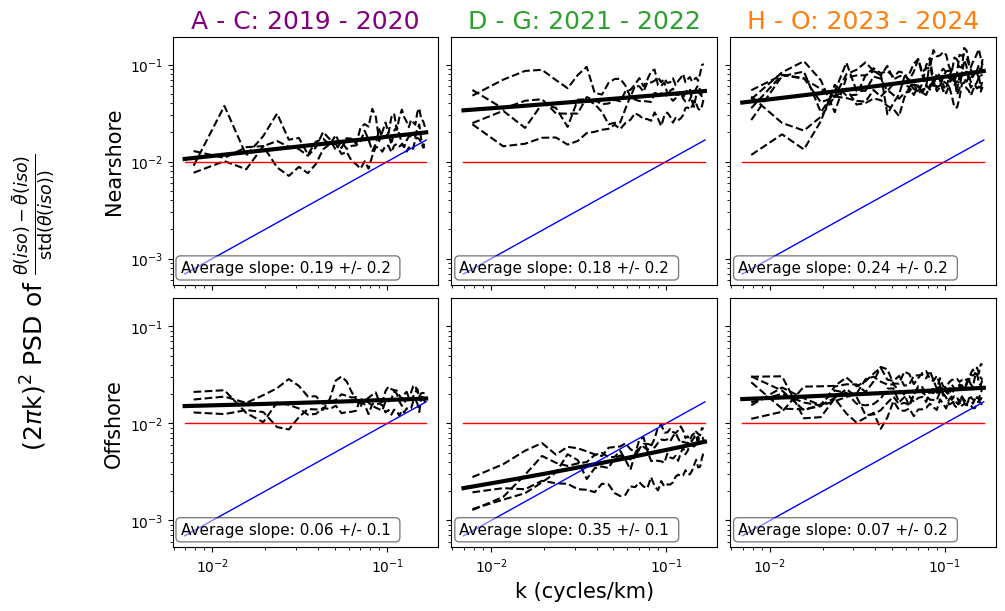

In [22]:
######nearshore vs offshore no depth 

fig, axs = plt.subplots(2,3, layout="constrained", sharey=True, sharex=True, figsize=(9,6))

##############
gr1_slope = []
gr1_b = []
gr2_slope = []
gr2_b = []
gr3_slope = []
gr3_b = []
gr1_slope_error = []
gr2_slope_error = []
gr3_slope_error = []
c=['purple','tab:green','tab:orange']

#######nearshore

for i in range(3):
    k_best_fit=spectra_groups_nearoff_no_d(near_spectra.isel(file=i), 0,0,None)
    
avg_line_no_d(k_best_fit, gr1_slope, gr1_b, gr2_slope, gr2_b, gr3_slope, gr3_b, gr1_slope_error,
         gr2_slope_error, gr3_slope_error, 0,0,None)


gr1_slope = []
gr1_b = []
gr2_slope = []
gr2_b = []
gr3_slope = []
gr3_b = []
gr1_slope_error = []
gr2_slope_error = []
gr3_slope_error = []
for i in range(3,7):
    k_best_fit=spectra_groups_nearoff_no_d(near_spectra.isel(file=i), 1,0,None)
    
avg_line_no_d(k_best_fit, gr1_slope, gr1_b, gr2_slope, gr2_b, gr3_slope, gr3_b, gr1_slope_error,
         gr2_slope_error, gr3_slope_error, 1,0,None)

gr1_slope = []
gr1_b = []
gr2_slope = []
gr2_b = []
gr3_slope = []
gr3_b = []
gr1_slope_error = []
gr2_slope_error = []
gr3_slope_error = []
for i in range(7,13):
    k_best_fit=spectra_groups_nearoff_no_d(near_spectra.isel(file=i), 2,0,None)
    
avg_line_no_d(k_best_fit, gr1_slope, gr1_b, gr2_slope, gr2_b, gr3_slope, gr3_b, gr1_slope_error,
         gr2_slope_error, gr3_slope_error, 2,0,None)

###########offshore

gr1_slope = []
gr1_b = []
gr2_slope = []
gr2_b = []
gr3_slope = []
gr3_b = []
gr1_slope_error = []
gr2_slope_error = []
gr3_slope_error = []
for i in range(3):
    k_best_fit=spectra_groups_nearoff_no_d(off_spectra.isel(file=i), 0,1,None)
    
avg_line_no_d(k_best_fit, gr1_slope, gr1_b, gr2_slope, gr2_b, gr3_slope, gr3_b, gr1_slope_error,
         gr2_slope_error, gr3_slope_error, 0,1,None)
gr1_slope = []
gr1_b = []
gr2_slope = []
gr2_b = []
gr3_slope = []
gr3_b = []
gr1_slope_error = []
gr2_slope_error = []
gr3_slope_error = []
for i in range(3,7):
    k_best_fit=spectra_groups_nearoff_no_d(off_spectra.isel(file=i), 1,1,None)
    
avg_line_no_d(k_best_fit, gr1_slope, gr1_b, gr2_slope, gr2_b, gr3_slope, gr3_b, gr1_slope_error,
         gr2_slope_error, gr3_slope_error, 1,1,None)

gr1_slope = []
gr1_b = []
gr2_slope = []
gr2_b = []
gr3_slope = []
gr3_b = []
gr1_slope_error = []
gr2_slope_error = []
gr3_slope_error = []
for i in range(7,13):
    k_best_fit=spectra_groups_nearoff_no_d(off_spectra.isel(file=i), 2,1,None)
    
avg_line_no_d(k_best_fit, gr1_slope, gr1_b, gr2_slope, gr2_b, gr3_slope, gr3_b, gr1_slope_error,
         gr2_slope_error, gr3_slope_error, 2,1,None)


#######
axs[0,0].set_title('A - C: 2019 - 2020',fontsize=18, c=c[0])
axs[0,1].set_title('D - G: 2021 - 2022',fontsize=18,c=c[1])
axs[0,2].set_title('H - O: 2023 - 2024',fontsize=18,c=c[2])

axs[0,0].text(-0.22, 0.5,'Nearshore', fontsize=15, ha='center',rotation='vertical', va='center', transform=axs[0, 0].transAxes)
axs[1,0].text(-0.22, 0.5,'Offshore', fontsize=15, ha='center', rotation='vertical',va='center', transform=axs[1, 0].transAxes)
fig.text(-0.1, 0.50, r' (2$\pi$k)$^{2}$ PSD of $\frac{\theta(iso) - \bar{\theta}(iso)}{\text{std}( \theta(iso))}$', va='center', rotation='vertical', fontsize=18)
axs[1,1].set_xlabel('k (cycles/km)',fontsize=15)

In [44]:
xr.DataArray(PSD, dims=('section', 'k')).mean('section') 


<xarray.DataArray (k: 41)> Size: 328B
array([4.08786942, 3.59379337, 1.17449308, 1.04306498, 0.8639398 ,
       0.43063217, 0.34362699, 0.21102899, 0.21842161, 0.23208157,
       0.18081012, 0.15408506, 0.11840972, 0.10682856, 0.09049128,
       0.07507144, 0.08060527, 0.08455456, 0.06659017, 0.07430877,
       0.06663104, 0.05409027, 0.04828689, 0.05129286, 0.0439037 ,
       0.04261175, 0.04687948, 0.03895113, 0.03801087, 0.03727817,
       0.03071309, 0.02788675, 0.02620964, 0.02628738, 0.02455048,
       0.02388286, 0.02744489, 0.02780712, 0.02072215, 0.01799729,
       0.01631765])
Dimensions without coordinates: k

# Spectra/transfer code

In [320]:
import logging
_log = logging.getLogger(__name__)

def gappy_interp(ds, *, dim='', xgrid=None, maxgap=np.inf):
    """

    OBSOLETE: use `ds.interpolate_na(maxgap=)
    interp ds on xgrid along dimension dim.  However don't
    interpolate across gaps larger than maxgap.



    Parameters
    ----------
    ds : xarray.DataSet or xarray.DataFrame
        data frame.  Must have *dim* as a dimension
    dim : string
        dimension to interpolate on.
    xgrid : array
        grid to interpolate to in dimension *dim*
    maxgap : float
        maximum size of gap in *dim* to interpolate across

    Returns
    -------
    DataSet or DataArray with dim=xgrid.

    Examples
    --------
    Note in the below that the gap from x=1 to 2.1 is _not_ interpolated over.

    >>> da = xr.DataArray(
        ...     data=[[1, 2, 3, 4, 5, 6]],
        ...     dims=("x"),
        ...     coords={"x": [0, 0.5, 1, 2.1, 2.5, 3.4]},
        ... )
    >>> dn = gappy_interp(da, dim='x', xgrid=np.arange(0, 3.1, 0.2), maxgap=1.0)
    >>> dn
    <xarray.DataArray (x: 16)>
    array([1.        , 1.4       , 1.8       , 2.2       , 2.6       ,
           3.        ,        nan,        nan,        nan,        nan,
           nan, 4.25      , 4.75      , 5.11111111, 5.33333333, 5.55555556])
    Coordinates:
    * x        (x) float64 0.0 0.2 0.4 0.6 0.8 1.0 1.2 ... 2.0 2.2 2.4 2.6 2.8 3.0
    """

    x0 = ds[dim].values
    print('xgrid:', xgrid)
    print('dim', dim)
    ds = ds.interp(**{dim:xgrid})
    dx = np.diff(x0)
    bad = (dx > maxgap).nonzero()[0]
    print("Bad", bad)
    mask = np.isfinite(xgrid)
    for b in bad:
        print("B", b, x0[b], x0[b+1])
        mask[(xgrid > x0[b]) & (xgrid < x0[b+1])] = False
    mask = xr.DataArray(mask, dims=(dim))
    return ds.where(mask)


def depth_to_iso(ds, pden='pden', depths='depths', xdim='along',
                 pden0=None, isodepths=None):
    """
    Map fields in this dataset to potential density coordinates.

    Parameters
    -----------

    ds : xarray Dataset
        Dataset that at least has *pden* and *depths* fields to map to

    pden : str (default 'pden')
        Name of Array in *ds* that has the density information.

    depths : str (default 'depths')
        Name of depth coordinate that has depth information.

    xdim : str (default 'along')
        Name of x coordinate of the data set

    pden0 : array-like (default None)
        Array of mean densities to interpolate onto.  If not provided, the
        data set mean is used.

    isodepths : array-like (default None)
        Mean depths of the isopycnals defined in *pden0*.
    """

    if pden0 is None:
        pden0 = ds[pden].mean(dim=xdim)
        isodepths = ds[depths].where(pden0 > 0).dropna(dim=depths)
        pden0 = pden0.dropna(dim=depths)

    M = pden0.shape[0]
    N = ds[xdim].shape[0]
    print(M, N)

    dsiso = xr.Dataset(coords={'isodepths':('isodepths', isodepths.values),
                               xdim: (xdim, ds[xdim].values)})
    print(dsiso)
    print(len(isodepths.values))
    for td in ds.variables:
        _log.info('todo', td, ds[td].shape)
        print(td, ds[td].shape)
        if td == xdim:
            pass
        elif td == depths:
            pass
        elif ds[td].shape == ds[xdim].shape:
            dsiso[td] = (xdim, ds[td].values)
        elif ds[td].shape == ds[pden].shape:
            dsiso[td] = (('isodepths', xdim), np.zeros((M, N)))
            for i in range(N):
                dsiso[td][:, i] = np.interp(pden0, ds[pden][:, i], ds[td].values[:, i])
        else:
            try:
                dsiso[td] = ds[td]
            except ValueError:
                pass

    return dsiso


def get_n_blocks(nfft, N, noverlap_min=None):
    if noverlap_min is None:
        noverlap_min = nfft / 2
    for m in range(2, 2000):
        noverlap = np.ceil(- (N - m * nfft) / (m - 1))
        if noverlap > 0 and noverlap >= noverlap_min:
            total = m * nfft - (m-1) * noverlap
            if total == nfft:
                noverlap = 0
            return int(noverlap), int(total), m


def power_spec(da, nfft=256, xdim='along', ydim='depths', xunits='km',
               dataunits='kg/m^3'):

    """
    Calculate power spectra segments of a DataArray and return as a Dataset.

    Parameters
    ----------

    da : DataArray
        data array to calculate spectra over.  Spectra are calculated in the
        second dimension, usually something like "x" or "time".

    nfft : integer
        length of FFT blocks

    xdim : string
        dimension in DataArray to calculate spectra along.

    ydim : string
        dimension in DataArray over which we iterate to calculate the spectra.

    xunits : string
        units of the xdimension

    dataunits : string
        units of the data that is being analyzed

    Returns
    -------

    ps : DataSet
        Data set with coordinates (blocks, depths, kx), if ydim is "depths".  Note that you
        may want to rename the coordinates if kx is a frequency.  Note that kx has units of
        cycles / km, *not* rad / km.  The spectrum has units of V^2 / cpkm, if "V" are the
        units of the data in *da*, and is normalized so that the integral of S(kx) dkx is
        equal to the variance of the signal in *da*.

    """
    N = da[xdim].shape[0]
    window = np.hanning(nfft)
    wnorm = (window * window).sum()
    noverlap, total, nblocks = get_n_blocks(nfft, N, noverlap_min=nfft/2)
    _log.info(noverlap, nblocks)
    dx = da[xdim].diff(dim=xdim).median().values
    kx = np.arange(0, 1/2-1e-5, 1/nfft) / dx
    ps =  xr.Dataset(coords={'blocks': np.arange(nblocks), 'depths': da[ydim].values, 'kx': kx })
    ps['kx'].attrs = {'description': 'wavenumber or frequency',
                      'units': f'cycles per {xunits}'}
    ps['spectrum'] = (('blocks', 'depths', 'kx'), np.zeros((nblocks, da[ydim].shape[0], len(kx))))
    ps['spectrum'].attrs = {'description': 'un-averaged power spectra from overlaping blocks',
                            'units': f'({dataunits})^2 / cp{xunits}',
                            'source': f'{da.name}'}
    ps['along_start'] = (('blocks'), np.zeros(nblocks))
    ps['along_stop'] = (('blocks'), np.zeros(nblocks))
    ps['along_start'].attrs = {'description' : f'start of the block in {xdim}'}
    ps['along_stop'].attrs = {'description' : f'start of the block in {xdim}'}
    ps['blocks'].attrs = {'description' : 'block index for the spectral estimates'}

    start = 0
    for nn in range(nblocks):
        stop = start + nfft
        _log.info(start, stop, da.isel({xdim: slice(start, stop)}).shape)
        xx = da.isel({xdim: slice(start, stop)})
        xx = xx - xx.mean(dim=xdim)
        ff = np.fft.fft(xx * window, axis=1)
        pp = ff[:, :int(nfft/2)]*np.conj(ff[:, :int(nfft/2)]) * 2 * dx / wnorm
        ps['spectrum'][nn, :, : ] = np.real(pp)
        ps['along_start'][nn] = da[xdim].isel({xdim:start})
        ps['along_stop'][nn] = da[xdim].isel({xdim: stop-1})
        start = stop - noverlap
    ps.attrs = {'nblocks': nblocks, 'noverlap': noverlap, 'nfft': nfft}
    return ps


def multi_psd(da, minnfft=64, xdim='along', ydim='depths', xunits='km',
              dataunits='kg/m^3'):

    """
    Calculate power spectra segments of a DataArray with different resolutions,
    and return a spectra.  Interpolate over gaps that are a bit larger than the resolution
    changes

    nfft: size of fft blocks to try.
        Maxgap for the current block will depend on the size of the next block.
    """
    N = len(da[xdim])
    # minnfft = 64
    
    #nffts = [2*int(np.floor(N/3/2)*2)]
    #nffts=[62*2*2]
    #while np.floor(nffts[-1]/6) > minnfft:
    #    nffts += [np.floor(nffts[-1]/6/2)*2]

    nffts = [64,64*2,64*2*2,64*2*2*2,64*2*2*2*2]#,,,,64*2*2*2*2*2,64*2*2*2*2*2*2, --taking these out for regimes
    maxgaps = nffts[1:]
    maxgaps += [2]
    maxgaps = maxgaps[::-1]
    # get the maxgap to interpolate over for each fft attempt
    spec = []
    kx = []
    for nn, nfft in enumerate(nffts[::-1]):
        dd = da.interpolate_na(dim=xdim, max_gap=maxgaps[nn])

        p = power_spec(dd, nfft=int(nfft), xdim=xdim, ydim=ydim,
                        xunits=xunits, dataunits=dataunits).mean(dim='blocks')
        if nn == 0:
            kmax = None
            spec = p.spectrum.values[:, 1:]
            kx = p.kx.values[1:]
        else:
            kmax = kx[0] - dkx / 2
            spec = np.concatenate((p.spectrum.sel(kx=slice(None, kmax)).values[:, 1:], spec), axis=1)
            kx = np.concatenate((p.kx.sel(kx=slice(None, kmax)).values[1:], kx))
        dkx = p.kx.diff(dim='kx').median(dim='kx')
    dout = xr.Dataset(coords={'depths': da[ydim].values, 'kx': kx })
    dout['kx'] = ('kx', kx)
    dout['spectrum'] = (('depths', 'kx'), spec)

    return dout


def whiten(kx, sp):
    return sp*(np.pi*2*kx)**2

In [575]:

def chi2_error_single_segment(psd: xr.DataArray, nu=2, ci=0.68):
    """
    Compute confidence intervals for a single-segment PSD assuming chi-squared distribution.

    Parameters
    ----------
    psd : xr.DataArray
        Power spectrum
    nu : int
        Degrees of freedom (2 for single segment)
    ci : float
        Confidence interval (e.g., 0.68 for 68%)

    Returns
    -------
    lower, upper : xr.DataArray
        Lower and upper confidence interval bounds
    """
    alpha = 1 - ci
    lower = psd * stats.chi2.ppf(alpha / 2, df=nu) / nu
    upper = psd * stats.chi2.ppf(1 - alpha / 2, df=nu) / nu
    return lower, upper


In [576]:
def block_avg_normalized_glider(file, file_transfer, size):
    # === Extract the iso_temps variable if it's a Dataset ===
    if isinstance(file, xr.Dataset):
        if "iso_temps" in file:
            file = file["iso_temps"]
        else:
            raise ValueError("Expected variable 'iso_temps' not found in dataset.")

    # Reverse order
    section = file.isel(distance=slice(None, None, -1))
    section_transfer = xr.open_dataset(transfer_path + file_transfer)

    # Normalize to anomalies
    anom = ((section - all_sections_combined.pot_temp_mean) /
            all_sections_combined.pot_temp_std).T

    # === Single-segment PSD (nfft = 4352) ===
    nfft = 3052
    section_block = power_spec(anom, nfft=nfft,
                               xdim='distance', ydim='depth',
                               xunits='km', dataunits='C').mean(dim='blocks')

    section_block = section_block.rename({'depths': 'depth', 'kx': 'k'})
    kx = section_block.k.values
    n_kx = kx.size

    # === Allocate fixed-size arrays ===
    block_transfer = np.full((1100, size), np.nan)
    block_PSD = np.full((1000, size), np.nan)

    # === Interpolate transfer function onto current kx and normalize PSD ===
    for i in range(1100):
        transfer_vals = np.interp(kx, section_transfer.k, section_transfer.transfer_fn[i].values)
        block_transfer[i, :n_kx] = transfer_vals

    for i in range(1000):
        psd_vals = section_block.spectrum[i].values
        block_PSD[i, :n_kx] = psd_vals / block_transfer[i, :n_kx]

    # === Wrap into xarray ===
    block_PSD = xr.DataArray(block_PSD, dims=('depth', 'k'))
    block_PSD.name = 'blocked_iso_potential_temp_PSD'
    block_PSD['depth'] = section.depth[:1000]
    block_PSD['k'] = np.linspace(kx[0], kx[-1], size)  # consistent dummy axis

    return block_PSD, block_PSD.k, block_PSD.depth


In [593]:
n_files = 15
depth_dim = 1000
k_dim = 2175

# Preallocate arrays
lower_all = np.full((depth_dim, k_dim, n_files), np.nan)
upper_all = np.full((depth_dim, k_dim, n_files), np.nan)

for i in range(n_files):
    print(f"Processing file {i}")
    try:
        psd, kx, dpth = block_avg_normalized_glider(
            all_sections_combined.isel(file=i, depth=slice(0, 1000)).sel(distance=slice(-80, -1178)),
             transfer[i], 2176
        )
        # Compute CI bounds using chi-squared method
        lower, upper = chi2_error_single_segment(psd[:,1:])

        lower_all[:, :, i] = lower
        upper_all[:, :, i] = upper

        if i == 0:
            k_used = kx.values
            depth_used = dpth.values

    except Exception as e:
        print(f"File {i} failed: {e}")

spectra_ci = xr.Dataset(
    {
        "ci_lower": (("depth", "k", "file"), lower_all),
        "ci_upper": (("depth", "k", "file"), upper_all),
    },
    coords={
        "k": k_used[1::],
        "depth": depth_used,
        "file": np.arange(n_files)
    }
)

spectra_ci.to_netcdf("glider_spectra_confidence_bounds.nc")

Processing file 0
Processing file 1
Processing file 2
Processing file 3
Processing file 4
Processing file 5
Processing file 6
Processing file 7
Processing file 8
Processing file 9
Processing file 10
Processing file 11
Processing file 12
Processing file 13
Processing file 14


In [578]:
spectra_all = np.empty((1000, 2176, 15))
spectra_all[:] = np.nan

for i in range(15):
    file = all_sections_combined.isel(file=i, depth=slice(0, 1000)).sel(distance=slice(-80, -1178))
    spec, kk, dpth = block_avg_normalized_glider(file, transfer[i], 2176)
    spectra_all[:, :, i] = spec
                                
all_spectra = xr.Dataset(
    {
        "spectra": (("depth", "k","file"), spectra_all[:,1::,:]),  
    },
    coords={
        "k": kk.values[1::],
        "depth": dpth.values,  
        "file": np.arange(0,15,1)
        
    }
)
all_spectra.to_netcdf('all_spectra.nc')

### Nearshore and offshore spectra

spectra_all = np.empty((1000,511,15))
spectra_all[:]=np.nan


for i in range(15):
    file = all_sections_combined.isel(file=i,depth=slice(0,1000)).sel(distance=slice(-80,-550))   
    spec,kk,dpth = block_avg_normalized(file,transfer[i],511)
    spectra_all[:,:,i]=spec
                                
near_spectra = xr.Dataset(
    {
        "spectra": (("depth", "k","file"), spectra_all[:,1::,:]),  
    },
    coords={
        "k": kk.values[1::],
        "depth": dpth.values,  
        "file": np.arange(0,15,1)
        
    }
)
spectra_all = np.empty((1000,511,15))
spectra_all[:]=np.nan


for i in range(15):
    file = all_sections_combined.isel(file=i,depth=slice(0,1000)).sel(distance=slice(-550,-1178))   
    spec,kk,dpth = block_avg_normalized(file,transfer[i],511)
    spectra_all[:,:,i]=spec
                                
off_spectra = xr.Dataset(
    {
        "spectra": (("depth", "k","file"), spectra_all[:,1::,:]),  
    },
    coords={
        "k": kk.values[1::],
        "depth": dpth.values,  
        "file": np.arange(0,15,1)
        
    }
)


off_spectra.to_netcdf('off_spectra.nc')
near_spectra.to_netcdf('near_spectra.nc')


In [579]:
def block_avg_normalized_mod(section, glider, size=2176):
    section = section.isel(distance=slice(None, None, -1))
    glider = glider.isel(distance=slice(None, None, -1))
    nfft = 3052

    anom = (section.T - glider.pot_temp_mean.values) / glider.pot_temp_std.values

    section_block = power_spec(anom.T, nfft=nfft,
                               xdim='distance', ydim='depth',
                               xunits='km', dataunits='C').mean(dim='blocks')

    section_block = section_block.rename({'depths': 'depth', 'kx': 'k'})
    kx = section_block.k.values
    n_kx = kx.size

    # Pad the spectrum to match target size
    block_PSD = np.full((1000, size), np.nan)
    block_PSD[:, :n_kx] = section_block.spectrum.values

    # Wrap in xarray
    block_PSD = xr.DataArray(block_PSD, dims=('depth', 'k'))
    block_PSD.name = 'blocked_iso_potential_temp_PSD'
    block_PSD['depth'] = section.depth[:1000]
    block_PSD['k'] = np.linspace(kx[0], kx[-1], size)

    return block_PSD, block_PSD.k, block_PSD.depth


In [580]:
mod_spectra_all = np.full((1000, 2176, 15), np.nan)

glider = all_sections_combined.isel(file=1, depth=slice(0, 1000)).sel(distance=slice(-80, -1178))

for i in range(15):
    print(f"Processing file {i}")
    try:
        spec, kx, dpth = block_avg_normalized_mod(
            all_synthetic.isel(file=i).sel(distance=slice(-80, -1178)).iso_temps,
            glider
        )

        n_kx = kx.size
        mod_spectra_all[:, :n_kx, i] = spec.values

        if i == 0:
            k_used = kx.values
            depth_used = dpth.values
    except Exception as e:
        print(f"File {i} failed: {e}")

mod_spectra_all = xr.Dataset(
    {
        "spectra": (("depth", "k", "file"), mod_spectra_all[:, 1:, :]),
    },
    coords={
        "k": k_used[1:],  # remove DC
        "depth": depth_used,
        "file": np.arange(15)
    }
)

mod_spectra_all.to_netcdf('mod_spectra_all.nc')       

Processing file 0
Processing file 1
Processing file 2
Processing file 3
Processing file 4
Processing file 5
Processing file 6
Processing file 7
Processing file 8
Processing file 9
Processing file 10
Processing file 11
Processing file 12
Processing file 13
Processing file 14


In [596]:
n_files = 15
depth_dim = 1000
k_dim = 2175
glider = all_sections_combined.isel(file=1, depth=slice(0, 1000)).sel(distance=slice(-80, -1178))

# Preallocate arrays
lower_all = np.full((depth_dim, k_dim, n_files), np.nan)
upper_all = np.full((depth_dim, k_dim, n_files), np.nan)

for i in range(n_files):
    print(f"Processing file {i}")
    try:
        psd, kx, dpth = block_avg_normalized_mod(
            all_synthetic.isel(file=i).sel(distance=slice(-80, -1178)).iso_temps,
            glider,
            size=2176
        )
        # Compute CI bounds using chi-squared method
        lower, upper = chi2_error_single_segment(psd[:,1:])

        lower_all[:, :, i] = lower
        upper_all[:, :, i] = upper

        if i == 0:
            k_used = kx.values[1::]
            depth_used = dpth.values

    except Exception as e:
        print(f"File {i} failed: {e}")

spectra_ci = xr.Dataset(
    {
        "ci_lower": (("depth", "k", "file"), lower_all),
        "ci_upper": (("depth", "k", "file"), upper_all),
    },
    coords={
        "k": k_used,
        "depth": depth_used,
        "file": np.arange(n_files)
    }
)

spectra_ci.to_netcdf("model_spectra_confidence_bounds.nc")

Processing file 0
Processing file 1
Processing file 2
Processing file 3
Processing file 4
Processing file 5
Processing file 6
Processing file 7
Processing file 8
Processing file 9
Processing file 10
Processing file 11
Processing file 12
Processing file 13
Processing file 14


spectra_all = np.empty((1000,511,15))
spectra_all[:]=np.nan

glider = all_sections_combined.isel(file=1,depth=slice(0,1000)).sel(distance=slice(-80,-550))   


for i in range(15):
    spec = block_avg_normalized(all_synthetic.isel(file=i).sel(distance=slice(-80,-550)).iso_temps,glider)
    spectra_all[:,:,i]=spec.blocked_iso_potential_temp_PSD
                                
mod_near_spectra = xr.Dataset(
    {
        "spectra": (("depth", "k","file"), spectra_all[:,1::,:]),  
    },
    coords={
        "k": spec.k[1::],
        "depth": spec.depth,  
        "file": np.arange(0,15,1)
        
    }
)

spectra_all = np.empty((1000,511,15))
spectra_all[:]=np.nan

glider = all_sections_combined.isel(file=1,depth=slice(0,1000)).sel(distance=slice(-550,-1200))   


for i in range(15):
    spec = block_avg_normalized(all_synthetic.isel(file=i).sel(distance=slice(-550,-1200)).iso_temps,glider)
    spectra_all[:,:,i]=spec.blocked_iso_potential_temp_PSD
                                
mod_off_spectra = xr.Dataset(
    {
        "spectra": (("depth", "k","file"), spectra_all[:,1::,:]),  
    },
    coords={
        "k": spec.k[1::],
        "depth": spec.depth,  
        "file": np.arange(0,15,1)
        
    }
)

mod_near_spectra.to_netcdf('mod_near_spectra.nc')
mod_off_spectra.to_netcdf('mod_off_spectra.nc')